# Example 3

### xTB descriptors to predict solubility using GNN

This workflow includes:

i) Train, Valid and Test split of Dataset \
ii) Setup of GNN model using nfp to predict solubility

#### Steps involved in this example

- Step 1: Import of nfp, tensorflow modules 
- Step 2: Read in solubility CSV and split data
- Step 3: Use nfp to set up GNN model
- Step 4: Predict using GNN model

###  Step 1: Import of nfp, tensorflow modules 

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import nfp

from tqdm import tqdm
tqdm.pandas()

print(f"tensorflow {tf.__version__}")
print(f"nfp {nfp.__version__}")

###  Step 2: Read in solubility CSV and split data

In [4]:
sol = pd.read_csv('solubility_xtb.csv')

In [68]:
# Split the data into training, validation, and test sets
valid, test, train = np.split(sol[['smiles','xtbjson']].sample(frac=1., random_state=30), [50, 100])

###  Step 3: Use nfp to set up GNN model

In [69]:
# Define how to featurize the input molecules
from nfp.preprocessing.xtb_preprocessor import xTBSmilesPreprocessor
from nfp.preprocessing.features import get_ring_size


def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return str((
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    ))


def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = 'R{}'.format(get_ring_size(bond, max_size=6)) if bond.IsInRing() else ''
    
    return " ".join([atoms, btype, ring]).strip()


preprocessor = xTBSmilesPreprocessor(atom_features=atom_featurizer, bond_features=bond_featurizer, xtb_bond_features=[], scaler=False)

In [70]:
train_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, row.xtbjson, train=True), row['measured log solubility in mols per litre'])
             for i, row in sol[sol.smiles.isin(train.smiles)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=(len(train)))\
    .prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, row.xtbjson, train=False), row['measured log solubility in mols per litre'])
             for i, row in sol[sol.smiles.isin(valid.smiles)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache()\
    .padded_batch(batch_size=(len(valid)))\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [71]:
inputs, outputs = next(train_dataset.as_numpy_iterator())

In [72]:
## Define the keras model
from tensorflow.keras import layers

# Define keras model
atom = layers.Input(shape=[None], dtype=tf.int64, name="atom")
bond = layers.Input(shape=[None], dtype=tf.int64, name="bond")
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name="connectivity")
atom_xtb = layers.Input(shape=[None, len(preprocessor.xtb_atom_features)], dtype=tf.float64, name="atom_xtb")

atom_features =8

#Input tensors
input_tensors = [atom, bond, connectivity, atom_xtb ]


# Initialize the atom states
atom_class = layers.Embedding(
    preprocessor.atom_classes,
    atom_features, name='atom_embedding', mask_zero=True)(atom)

atom_class_xtb = layers.Dense(atom_features,activation='relu')(atom_xtb)

atom_state = layers.Concatenate(axis=-1)([atom_class, atom_class_xtb])

atom_state = layers.Dense(atom_features)(atom_state)


# Initialize the bond states
bond_state = layers.Embedding(
    preprocessor.bond_classes,
    atom_features, name='bond_embedding', mask_zero=True)(bond)

# Here we use our first nfp layer. This is an attention layer that looks at
# the atom and bond states and reduces them to a single, graph-level vector. 
# mum_heads * units has to be the same dimension as the atom / bond dimension
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(3):  # Do the message passing
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = layers.Add()([bond_state, new_bond_state])
    
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = layers.Add()([atom_state, new_atom_state])
    
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = layers.Add()([global_state, new_global_state])

    
# Since the final prediction is a single, molecule-level property (YSI), we 
# reduce the last global state to a single prediction.
sol_prediction = layers.Dense(1)(global_state)

# Construct the tf.keras model
model = tf.keras.Model([atom, bond, connectivity, atom_xtb], [sol_prediction])

In [73]:
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(1E-3))

# Fit the model. The first epoch is slower, since it needs to cache
# the preprocessed molecule inputs
model.fit(train_dataset, validation_data=valid_dataset, epochs=500)

Epoch 1/500


/apps/conda/svss/envs/tf2_gpu7/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bond_xtb', 'bond_indices', 'bond_atom_indices', 'atom_indices', 'mol_xtb'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 6s 6s/step - loss: 169.6597 - val_loss: 113.3150
Epoch 2/500
1/1 [==============================] - 0s 492ms/step - loss: 120.9612 - val_loss: 78.2040
Epoch 3/500
1/1 [==============================] - 0s 387ms/step - loss: 85.3626 - val_loss: 50.9738
Epoch 4/500
1/1 [==============================] - 0s 425ms/step - loss: 54.3350 - val_loss: 27.8020
Epoch 5/500
1/1 [==============================] - 0s 452ms/step - loss: 29.5760 - val_loss: 22.6345
Epoch 6/500
1/1 [==============================] - 0s 478ms/step - loss: 21.2997 - val_loss: 22.8894
Epoch 7/500
1/1 [==============================] - 0s 422ms/step - loss: 23.8217 - val_loss: 24.2598
Epoch 8/500
1/1 [==============================] - 0s 415ms/step - loss: 27.7621 - val_loss: 25.4050
Epoch 9/500
1/1 [==============================] - 0s 474ms/step - loss: 31.1940 - val_loss: 25.6179
Epoch 10/500
1/1 [==============================] - 0s 416ms/step - loss: 31.5348 - val_loss: 23.9159
E

### Step 4: Predict using GNN model

In [74]:
# Here, we create a test dataset that doesn't assume we know the values for the YSI

test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor(row.smiles, row.xtbjson, train=False)
             for i, row in test.iterrows()),
    output_signature=preprocessor.output_signature)\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [75]:
# Here are the predictions on the test set
test_predictions = model.predict(test_dataset)
test_db_values = sol.set_index('smiles').reindex(test.smiles)['measured log solubility in mols per litre'].values

np.abs(test_db_values - test_predictions.flatten()).mean()

1.1288179427146912

In [76]:
# Here are the predictions on the test set
train_predictions = model.predict(train_dataset)
train_db_values = sol.set_index('smiles').reindex(train.smiles)['measured log solubility in mols per litre'].values

np.abs(train_db_values - train_predictions.flatten()).mean()

/apps/conda/svss/envs/tf2_gpu7/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bond_xtb', 'bond_indices', 'bond_atom_indices', 'atom_indices', 'mol_xtb'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2.211203643199245

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

/apps/conda/svss/envs/tf2_gpu7/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


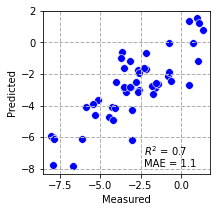

In [82]:
fig = plt.subplots(figsize=(3,3))

# ax1 = sns.scatterplot(train_db_values,train_predictions.flatten(),s=30,marker='o',color='b')
ax1 = sns.scatterplot(test_db_values,test_predictions.flatten(),s=60,marker='o',color='b')

# ax1.set_title('log solubility (mols/litre)', fontsize=10)
ax1.set_xlabel(r'Measured',fontsize=10)
ax1.set_ylabel(r'Predicted',fontsize=10)

ax1.grid(linestyle='--', linewidth=1)

mae = metrics.mean_absolute_error(test_db_values,test_predictions.flatten())
r2 = metrics.r2_score(test_db_values,test_predictions.flatten())

plt.annotate(f"$R^2$ = {round(r2,1)} \nMAE = {round(mae,1)} ", xy=(-2.3, -7.9), fontsize=10)
plt.savefig('solubility-gnn.jpg',dpi=400)
plt.show()